*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Regression

TODO: intro

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/regression.ipynb).

In [581]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [582]:
from os.path import basename, exists


def download(url, filename=None):
    if filename is None:
        filename = basename(url)
        
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [583]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

In [584]:
from utils import set_precision

set_precision(4)

## Regression as Minimization

Before we think of regression as a linear algebra problem, let's start with minimization.
Specifically, we'll start with **least squares regression**, which minimizes the sum of squared errors.

As the smallest example, I'll construct a predictor, `x`, and a response variable, `y` -- sometimes called independent and dependent variables.

In [585]:
x = np.array([2, 1, 0]) + 0.1
y = 0.5 + 0.8 * x + [-0.1, -0.2, 0.3]
y

array([2.08, 1.18, 0.88])

A natural way to visualize this dataset is to plot `y` versus `x`.

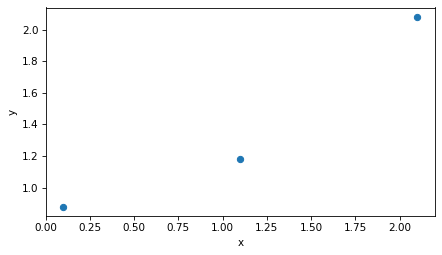

In [586]:
plt.plot(x, y, 'o')
decorate(xlabel='x', ylabel='y')

There's no line that goes through all three points, so we'll find a line of **best fit**.
First we'll construct the **design matrix**, which contains two columns: the first is all `1`s, and the second is the predictor, `x`.

In [587]:
from sympy import Matrix

X = np.column_stack((np.ones_like(x), x))
Matrix(X)

Matrix([
[1.0, 2.1],
[1.0, 1.1],
[1.0, 0.1]])

Now the goal is to find a vector of parameters, `beta`, the contains the intercept and slope of the fitted line.
We'll start with a not very good guess about the line of best fit.

In [588]:
beta = np.array([1, 0.4])

To see how good that choice is, we can evaluate the line at each location in `x`.

In [589]:
y_fit = X @ beta

The errors, also called **residuals**, are the vertical distances between the actual values, `y`, and the fitted line. 

In [590]:
r = y - y_fit
r

array([ 0.24, -0.26, -0.16])

Here's what that looks like.
The dots are the actual values, the solid line is the not-very-good fit, and the vertical dotted lines show the residuals.

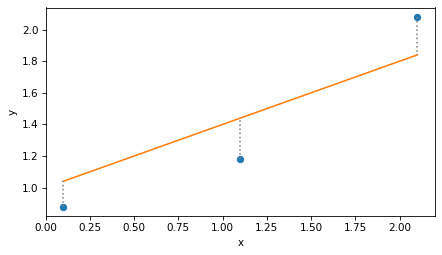

In [591]:
plt.plot(x, y, 'o')
plt.plot(x, y_fit)
plt.vlines(x, y, y_fit, ls=':', color='gray')
decorate(xlabel='x', ylabel='y')

To compute the **residual sum of squares**, we use array operations.

In [592]:
np.sum(r**2)

0.1508

Or equivalently, we can compute the dot product of the residuals.

In [613]:
r @ r

0.0600

Here's a function that takes a hypothetical vector of coefficients, `beta`, and returns the residual sum of squares, `rss`.

In [594]:
def rss_func(beta, X, y):
    r = y - X @ beta
    return np.dot(r, r)

Here's the result for the example.

In [595]:
rss_func(beta, X, y)

0.1508

That function works with the `minimize` function from SciPy to efficiently search for the value of `beta` that minimizes `rss`.

In [596]:
from scipy.optimize import minimize

result = minimize(rss_func, beta, args=(X, y))
result.message

'Optimization terminated successfully.'

The message indicates that the iterative search converged to a minimum.
`nfev` is the number of function evaluations -- that is, the number of times `minimize` called `rss_func` with different values of `beta`.

In [597]:
result.nfev

15

And here's the result, which we'll call `beta_hat` because the conventional notation for this result is $\hat{\beta}$, and the caret is almost universally called a "hat".

In [598]:
beta_hat = result.x
beta_hat

array([0.72, 0.6 ])

We can confirm that this value of `beta` yields a lower `rss` than the initial guess. 

In [599]:
rss_func(beta_hat, X, y)

0.0600

If we use `beta_hat` to compute fitted values, the result is called `y_hat`.

In [600]:
y_hat = X @ beta_hat

And here's what the least squares fit looks like.

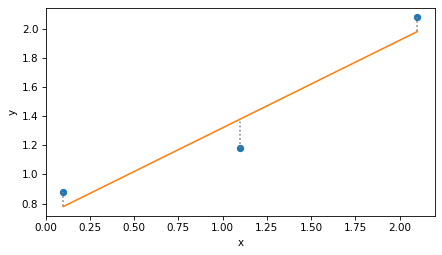

In [601]:
plt.plot(x, y, 'o')
plt.plot(x, y_hat)
plt.vlines(x, y, y_hat, ls=':', color='gray')
decorate(xlabel='x', ylabel='y')

Again, the dotted lines represent the residuals, `r`, and the residual sum of squares is the dot product of `r` with itself.

In [612]:
r = y - y_hat
r @ r

0.0600

To be honest, minimization is not a terrible way to solve regression problems, and it generalizes easily to other definitions of "best" and other kinds of regression.
But if we write linear least squared regression as an overconstrained matrix equation, this formulation has an elegant and efficient solution. 

## Projection

Now let's do some linear algebra.
We'll pull out the columns of the design matrix, `X`, as three-dimensional vectors `v1` and `v2`.

In [602]:
v1, v2 = np.transpose(X)
v1

array([1., 1., 1.])

In [603]:
v2

array([2.1, 1.1, 0.1])

The linear combinations of these vector span a two dimensional plane in three dimensions.
The following figure shows this plane.

It also shows the response variable, `y`, which we can also think of as a vector in three dimensions, as well as the vector of fitted values, `y_hat`.

In [604]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_vectors(
    vectors,
    origin=None,
    start=0,
    end=None,
    scale=1,
    labels=None,
    label_pos=None,
    **options
):
    """Plot a set of vectors in 2D or 3D.

    Args:
        vectors: list of vectors or array with one row per vector (shape: (N, 2) or (N, 3))
        origin: list of vectors or array with one row per vector (default: all at (0,0) or (0,0,0))
        start: integer slice index
        end: integer slice index
        scale: factor to multiply vectors
        labels: list of string labels
        label_pos: list of locations as integer clock positions (only for 2D)
        options: passed to plt.quiver
    """
    vectors = np.asarray(vectors) * scale
    dim = vectors.shape[1]  # Determine 2D vs. 3D

    if origin is None:
        origin = np.zeros_like(vectors)
    else:
        origin = np.asarray(origin)

    underride(
        options,
        color="C0",
        alpha=0.6,
    )

    ax = plt.gca()
    if dim == 2:
        # 2D case using plt.quiver
        us, vs = vectors[start:end].T
        xs, ys = origin[start:end].T

        underride(
            options,
            angles="xy",
            scale_units="xy",
            scale=1,
        )

        ax.scatter(xs, ys, s=0)
        ax.scatter(xs + us, ys + vs, s=0)
        ax.quiver(xs, ys, us, vs, **options)

    elif dim == 3:
        # 3D case using ax.quiver
        us, vs, ws = vectors[start:end].T
        xs, ys, zs = origin[start:end].T

        underride(
            options,
            arrow_length_ratio=0.1,
        )

        ax.scatter(xs, ys, zs, s=0)
        ax.scatter(xs + us, ys + vs, zs + zs, s=0)
        ax.quiver(xs, ys, zs, us, vs, ws, **options)

    else:
        raise ValueError("Only 2D and 3D vectors are supported.")

In [605]:
def plot_plane(v1, v2, origin=None, **options):
    """Plot a shaded plane spanned by two vectors in 3D.

    Args:
        v1: First vector defining the plane (array-like, shape (3,))
        v2: Second vector defining the plane (array-like, shape (3,))
        origin: Origin point of the plane (default: [0, 0, 0])
        options: Passed to plot_surface (e.g., color, alpha)
    """
    v1, v2 = np.asarray(v1), np.asarray(v2)

    if len(v1) != 3 or len(v2) != 3:
        raise ValueError("plot_plane requires 3D vectors.")

    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.asarray(origin)

    # Generate a mesh grid for the plane
    u = [0, 1]
    v = [0, 1]
    U, V = np.meshgrid(u, v)

    # Plane equation: P = origin + U * v1 + V * v2
    X = origin[0] + U * v1[0] + V * v2[0]
    Y = origin[1] + U * v1[1] + V * v2[1]
    Z = origin[2] + U * v1[2] + V * v2[2]

    underride(options, color="gray", alpha=0.3)

    # Plot the plane
    ax = plt.gca()
    ax.plot_surface(X, Y, Z, **options)

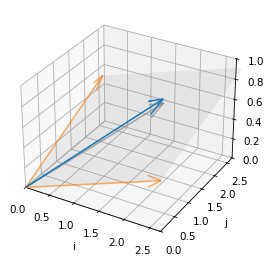

In [606]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

plot_plane(v1, v2, alpha=0.08)
plot_vectors([v1, v2], color='C1')
plot_vectors([y], alpha=1)
plot_vectors([y_hat], color='gray')

lim = [0, 2.7]
decorate(xlim=lim, ylim=lim, zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

`y` does not fall in the plane, which means it cannot be expressed as a linear combination of the columns of `X`.

But `y_hat` *does* fall in the plane, because it is a combination of the columns of `X` -- specifically, `y_hat = X @ beta`.

The difference between `y` and `y_hat` is the residual, `r`, which we can also think of as a vector in this space.
This vector has two important properties.
First, the length of `r`, squared, is the residual sum of squares.

In [616]:
norm(r) ** 2

0.0600

Second, `r` is perpendicular to the columns of `X`, which we can confirm by showing that their dot product is close to zero.

In [614]:
X.T @ r

array([-7.9582e-09, -7.7054e-09])

This result means that `y_hat`, the fitted values that minimize RSS, is the **projection** of `y` onto the plane defined by `v1` and `v2` -- that is, the vector in the plane that's closest to `y`.

This insight is the key to an efficient way to compute `y_hat`, using QR decomposition.


## QR Decomposition

QR composition is similar to LU decomposition, which we used to solve systems of linear equations efficiently.
In LU decomposition, we express a matrix, `A`, as the product of two matrices, one lower-diagonal and one upper-diagonal.

In QR decomposition, we'll express the design matrix, `X`, as the product of two matrices, one **orthonormal** and one upper diagonal.

To explain what an orthonormal matrix is, and why it is useful, we'll use the NumPy function `qr` to compute the decomposition.
In the next section we'll see how this function works.

In [ ]:
Q, R = np.linalg.qr(X)

The results are two matrices. `Q` is the same size as `X`.

In [88]:
Q

array([[-5.7735e-01,  7.0711e-01],
       [-5.7735e-01,  5.5511e-17],
       [-5.7735e-01, -7.0711e-01]])

And `R` has the same number of columns as `X`, but it's square and upper triangular.

In [89]:
R

array([[-1.7321, -1.9053],
       [ 0.    ,  1.4142]])

First let's confirm that $Q R = X$. 

In [617]:
np.allclose(Q @ R, X)

True

Now if `Q` is orthonormal, the "ortho" part means that the columns are perpendicular to each other, and the "normal" part means the norm of the columns is `1`.
We can confirm both by computing the dot product of the columns with themselves.

In [618]:
Matrix(Q.T @ Q)

Matrix([
[                  1.0, -1.16219581322268e-16],
[-1.16219581322268e-16,                   1.0]])

The off-diagonal elements are close to zero, which confirms that the columns are orthogonal to each other, and the diagonal elements are 1, which confirms that their norm is 1.

But also notice that the product of $Q^T$ and $Q$ is the identity matrix, $I$, which means that $Q^T$ is the inverse of $Q$.

And *that* means we can solve the equation 

$Q \beta' = y$ 

by multiplying both sides by $Q^T$, which yields 

$Q^T Q \beta' = Q^T y$, 

which yields 

$\beta' = Q^T y$.

In [92]:
beta_prime = Q.T @ y
beta_prime

array([-2.3902,  0.8485])

And why would we want to solve $Q \beta' = y$?
Because the result is the coordinates of $\hat{y}$ in the span of $Q$.
We can confirm that by multiplying those coordinates by the columns of $Q$.

In [93]:
y_hat = Q @ beta_prime
y_hat

array([1.98, 1.38, 0.78])

And the result is the same as the `y_hat` we computed by minimizing RSS.
Combining the last two steps, we could have computed.

In [619]:
y_hat = Q @ Q.T @ y
y_hat

array([1.98, 1.38, 0.78])

Instead of multiplying `y` by `Q.T` first, we could multiply `Q` and `Q.T` first.

In [94]:
P = Q @ Q.T
P

array([[ 0.8333,  0.3333, -0.1667],
       [ 0.3333,  0.3333,  0.3333],
       [-0.1667,  0.3333,  0.8333]])

The result is a projection matrix that projects any vector into the span of `Q`.

In [95]:
y_hat = P @ y
y_hat

array([1.98, 1.38, 0.78])

Normally we would not compute `P` explicitly, but it is useful for confirming an important property of `Q`, which is that it has the same span as `X`.
We can show that by projecting the columns of `X` onto `Q`.

In [621]:
P @ X

array([[1. , 2.1],
       [1. , 1.1],
       [1. , 0.1]])

And confirming that the result is `X`.

In [622]:
np.allclose(P @ X, X)

True

Which shows that the plane spanned by `Q` is the same as the plane spanned by `X`.
Here's what that looks like in the diagram.

In [98]:
q1, q2 = Q.T

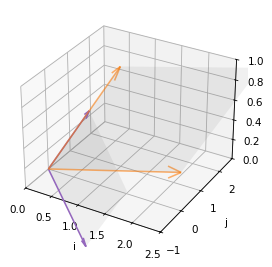

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

plot_plane(v1, v2, alpha=0.08)
plot_plane(-q1, q2, alpha=0.08)
plot_vectors([v1, v2], color='C1')
plot_vectors([-q1, q2], color='C4', alpha=1)

lim = [0, 2.5]
decorate(xlim=lim, ylim=[-1, 2.7], zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

Because of the limitations of 3D visualization, it might not be obvious that the two shaded areas are in the same plane -- but they are.

This property is important because it means that projecting `y` onto `Q` is the same as projecting `y` onto `X`, which minimizes RSS -- so we are almost there!

`beta_prime` contains the coordinates of `y_hat` in terms of the columns of `Q`, so the last step is to transform them into the coordinates of `y_hat` in terms of the columns of `X`.

So how do we do that?

What we want is a $\beta$ such that `X \beta = \hat{y}`, but what we have is a $\beta'$ such that `Q \beta' = \hat{y}`.
Setting the left sides equal, we have

$X \beta = Q \beta'$

Replacing $X$ with $QR$ we have

$Q R \beta = Q \beta'$

Multiplying through by $Q^{-1}$, we can cancel $Q$ on both sides, leaving

$R \beta = \beta'$

So we can find $\beta$ by solving this equation.
Since $R$ is upper triangular, we can use `solve_triangular`, which is more efficient that the more general `solve` function.

In [100]:
from scipy.linalg import solve_triangular

beta_qr = solve_triangular(R, beta_prime, lower=False)
beta_qr

array([0.72, 0.6 ])

The argument `lower=False` indicates that `R` is upper triangular.
And the result is the same as the `beta` we computed by minimization.

It took a few steps to get here, but now we can write the whole process in just two lines.

In [625]:
def lstsq(X, y):
    Q, R = np.linalg.qr(X)
    beta = solve_triangular(R, Q.T @ y, lower=False)
    return beta

And we get the same result.

In [626]:
lstsq(X, y)

array([0.72, 0.6 ])

SciPy provides a similar function with addition capabilities.

In [628]:
import scipy

beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')

The argument `lapack_driver='gelsy'` specifies which function to use.
The "ge" part of the name means it works with general matrices -- not necessarily symmetric, for example.
The "ls" part means it computes least squares.
And "y" is the arbitrary name for the variant that uses QR decomposition.

The first return value is `beta` again. 

In [104]:
beta

array([0.72, 0.6 ])

The second and fourth return values are used by other solvers, but not `gelsy`.
And the third return value is the rank of the design matrix, which is usually the number of columns in `X`.

In [105]:
rank

2

But if some of the columns are linear combinations of others, the rank might be lower.
We'll see an example of that soon, but first we have a loose end to tie up -- how do we compute the QR decomposition?

## Orthogonalization

In [41]:
from utils import norm, normalize

v1, v2 = X.T
norm(v1)

1.7321

In [42]:
v1_hat = normalize(v1)
v1_hat

array([0.5774, 0.5774, 0.5774])

In [43]:
v2_perp = v2 - vector_projection(v2, v1)

In [44]:
v2_hat = normalize(v2_perp)
v2_hat

array([ 0.7071,  0.    , -0.7071])

In [45]:
v1 @ v2_perp

0.0000

In [46]:
Q = np.column_stack([v1_hat, v2_hat])
Q

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

In [47]:
Q.T @ Q

array([[ 1.0000e+00, -1.7796e-17],
       [-1.7796e-17,  1.0000e+00]])

In [106]:
def gram_schmidt(X):
    basis = []
    for v in X.T:
        for b in basis:
            v -= vector_projection(v, b)
        basis.append(normalize(v))
    return np.transpose(basis)

In [107]:
gram_schmidt(X)

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

In [ ]:
def gram_schmidt(X):
    """
    Classical Gram-Schmidt.

    Args:
        X: array (m, n) with n input vectors as columns.

    Returns:
        Q: (m, n) with orthonormal columns
        R: (n, n) upper triangular
    """
    m, n = X.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = X[:, j].copy()
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X[:, j])
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    
    return Q, R

In [57]:
Q, R = gram_schmidt(X)
Q

array([[ 5.7735e-01,  7.0711e-01],
       [ 5.7735e-01, -1.5701e-16],
       [ 5.7735e-01, -7.0711e-01]])

In [49]:
R

array([[1.7321, 1.9053],
       [0.    , 1.4142]])

In [58]:
np.allclose(Q @ R, X)

True

## Putting it together

## Multiple Regression

In [308]:
download('https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_extract_2024_1.hdf')

In [309]:
gss = pd.read_hdf('gss_extract_2024_1.hdf')

In [420]:
columns = ['polviews', 'year', 'cohort']
subset = gss.dropna(subset=columns)[columns]
subset['age'] = subset['year'] - subset['cohort']
subset.describe()

,polviews,year,cohort,age
count,65239.0000,65239.0000,65239.0000,65239.0000
mean,4.1086,1999.9547,1954.8059,45.1488
std,1.4057,15.2522,21.9236,17.2269
min,1.0000,1974.0000,1885.0000,18.0000
25%,3.0000,1987.0000,1941.0000,31.0000
50%,4.0000,2000.0000,1956.0000,43.0000
75%,5.0000,2014.0000,1969.0000,58.0000
max,7.0000,2024.0000,2006.0000,90.0000


In [421]:
import numpy as np

def add_constant(X):
    """Add an intercept column of ones to a 1D or 2D array-like X.
    
    Args:
        X: array-like, shape (n,) or (n, m)
    
    Returns:
        array of shape (n, m+1) with a column of ones prepended
    """
    X = np.asarray(X)

    # If X is 1D, make it a column vector
    if X.ndim == 1:
        X = X[:, np.newaxis]

    n = X.shape[0]
    ones = np.ones((n, 1))
    return np.column_stack([ones, X])


In [422]:
response = 'polviews'
y = subset[response]

In [423]:
predictor = 'age'
means_age = subset.groupby(predictor)[response].mean()

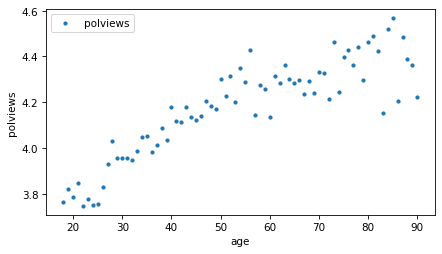

In [424]:
means_age.plot(style='.')
decorate(xlabel=predictor, ylabel=response)

In [425]:
predictors = [predictor]
X = add_constant(subset[predictors])
X.shape

(65239, 2)

In [426]:
beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')
rank, beta

(2, array([3.6416, 0.0103]))

In [427]:
fit_x = np.arange(18, 90)
fit_y = add_constant(fit_x) @ beta

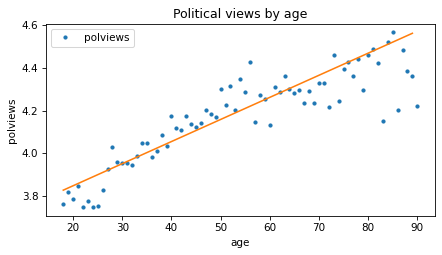

In [428]:
means_age.plot(style='.')
plt.plot(fit_x, fit_y)

decorate(xlabel=predictor, ylabel=response, title='Political views by age')

In [429]:
from dataclasses import dataclass

@dataclass
class RegressionResult:
    means: np.ndarray
    cond_number: float
    rank: int
    beta: np.ndarray
    fit_y: np.ndarray

In [464]:
def fit_model(df, response, predictors, fit_x):
    # group means by the first predictor
    means = df.groupby(predictors[0])[response].mean()

    # response and design matrix
    y = df[response]
    X = add_constant(df[predictors])

    # condition number of design matrix
    cond_number = np.linalg.cond(X)

    # least squares fit
    beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')

    # fitted values for new X
    fit_y = add_constant(fit_x) @ beta

    return RegressionResult(means, cond_number, rank, beta, fit_y)

In [465]:
predictor = 'cohort'
fit_x = np.arange(1880, 2010)
result = fit_model(subset, response, [predictor], fit_x)
result.rank, np.log10(result.cond_number)

(2, 174322.2522)

In [468]:
color_map = {
    'age': 'C0',
    'year': 'C2',
    'cohort': 'C4',
}

def plot_result(response, predictor, result, fit_x):
    result.means.plot(style='.', color=color_map[predictor])
    plt.plot(fit_x, result.fit_y, color='C1')

    decorate(xlabel=predictor, 
             ylabel=response, 
             title=f'{response} by {predictor}')

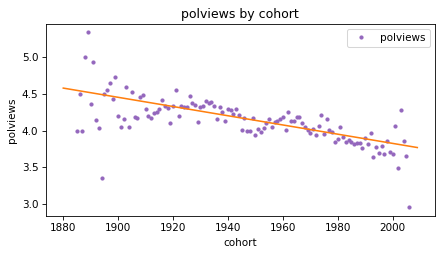

In [469]:
plot_result(response, predictor, result, fit_x)

In [470]:
predictor = 'year'
fit_x = np.arange(1970, 2024)
result = fit_model(subset, response, [predictor], fit_x)
result.rank, np.log10(result.cond_number)

(2, 262262.0771)

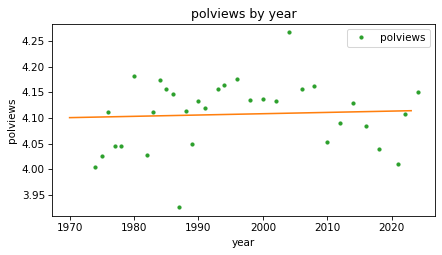

In [471]:
plot_result(response, predictor, result, fit_x)

In [473]:
subset['year2'] = subset['year'] ** 2

In [474]:
fit_x0 = np.arange(1970, 2024)
fit_x1 = fit_x0 ** 2
fit_X = np.column_stack([fit_x0, fit_x1])

In [475]:
predictors = ['year', 'year2']
result = fit_model(subset, response, predictors, fit_X)
result.rank, np.log10(result.cond_number)

(3, 2685510.1072)

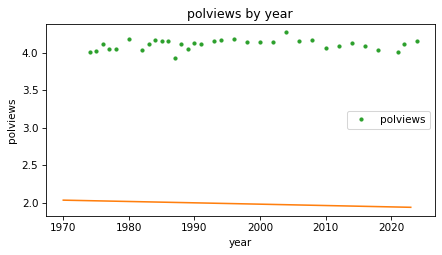

In [476]:
plot_result(response, predictors[0], result, fit_x0)

In [477]:
subset['year2'] = (subset['year'] - 2000) ** 2

In [478]:
fit_x0 = np.arange(1970, 2024)
fit_x1 = (fit_x0 - 2000) ** 2
fit_X = np.column_stack([fit_x0, fit_x1])

In [479]:
predictors = ['year', 'year2']
result = fit_model(subset, response, predictors, fit_X)
result.rank, np.log10(result.cond_number)

(3, 264089.0705)

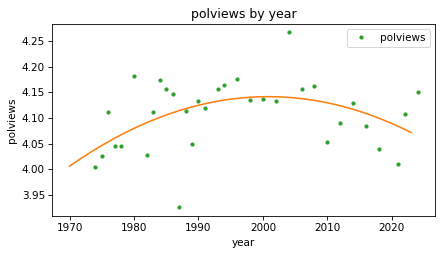

In [480]:
plot_result(response, predictors[0], result, fit_x0)

## Multiple Regression

In [503]:
predictors = ['age', 'cohort']
fit_x0 = np.arange(18, 90)

cohorts = [1920, 1960, 2000]
fits = {}

for cohort in cohorts:
    fit_x1 = np.full_like(fit_x0, cohort)
    fit_X = np.column_stack([fit_x0, fit_x1])

    result = fit_model(subset, response, predictors, fit_X)
    fits[cohort] = result.fit_y

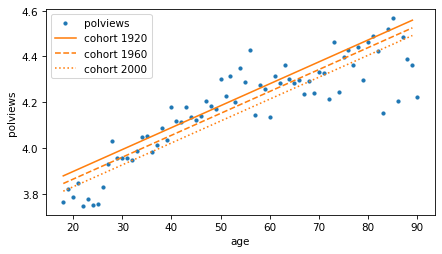

In [504]:
means_age.plot(style='.', color='C0')
style_map = dict(zip(cohorts, ['-', '--', ':']))
   
for cohort, fit_y in fits.items():
    plt.plot(fit_x0, fit_y, style_map[cohort], color='C1', label=f'cohort {cohort}')

decorate(xlabel=predictors[0], ylabel=response)

In [543]:
predictors = ['age', 'cohort', 'year']
fit_x0 = np.array([18])
fit_x1 = np.full_like(fit_x0, 2000)
fit_x2 = np.full_like(fit_x0, 2018)
fit_X = np.column_stack([fit_x0, fit_x1, fit_x2])

result = fit_model(subset, response, predictors, fit_X)
result.rank, np.log10(result.cond_number)

(3, 9887806182996954.0000)

In [544]:
result.fit_y

array([3.8108])

In [545]:
result.beta

array([ 5.3109e+00,  6.6641e-03, -3.7502e-03,  2.9139e-03])

In [546]:
def resample(df, seed):
    return df.sample(len(df), replace=True, random_state=seed)

In [552]:
betas = []
fits = []
for seed in range(5):
    sample = resample(subset, seed)
    result = fit_model(sample, response, predictors, fit_X)
    betas.append(result.beta)
    fits.append(result.fit_y[0])
    
df = pd.DataFrame(betas, columns=['intercept', 'age', 'cohort', 'year'])
df['fit'] = fits
df

,intercept,age,cohort,year,fit
0,5.7593,0.0067,-0.0039,0.0028,3.8056
1,6.3089,-3485831086.9779,-3485831086.9882,3485831086.9868,3.8037
2,6.0750,-3445354991.4831,-3445354991.4937,3445354991.4925,3.7920
3,5.5778,-6178943318.5377,-6178943318.5484,6178943318.5475,3.8047
4,4.6525,2874672694.1160,2874672694.1059,-2874672694.1064,3.8311


## Trilateration

In [108]:
import numpy as np

def trilateration_algebraic(beacons, ranges, ref_idx=0):
    """
    Algebraic LS trilateration in 2D.
    beacons: (m,2) array of [xi, yi]
    ranges:  (m,)  array of ri
    ref_idx: index k to use as reference equation
    Returns: x_hat, y_hat
    """
    C = np.asarray(beacons, float)
    r = np.asarray(ranges, float)
    k = ref_idx

    idx = [i for i in range(len(C)) if i != k]
    xi, yi = C[idx, 0], C[idx, 1]
    xk, yk = C[k, 0], C[k, 1]
    ri2, rk2 = r[idx]**2, r[k]**2

    A = np.column_stack([2*(xk - xi), 2*(yk - yi)])
    b = ri2 - rk2 + xk**2 - xi**2 + yk**2 - yi**2

    # LS solve via QR/SVD under the hood
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    return sol[0], sol[1]

def trilateration_refine_geometric(beacons, ranges, p0, steps=5, lam=0.0):
    """
    Few Gauss–Newton / LM refinement steps for geometric LS.
    lam=0 gives Gauss–Newton; lam>0 gives Levenberg–Marquardt damping.
    """
    p = np.array(p0, float)
    C = np.asarray(beacons, float)
    r = np.asarray(ranges, float)

    for _ in range(steps):
        d = np.linalg.norm(p - C, axis=1)
        e = d - r
        # Jacobian m x 2
        J = (p - C) / d[:, None]
        # Solve (J^T J + lam I) Δ = -J^T e
        JTJ = J.T @ J
        g = J.T @ e
        H = JTJ + lam * np.eye(2)
        delta = -np.linalg.solve(H, g)
        p = p + delta
        if np.linalg.norm(delta) < 1e-9:
            break
    return p


In [112]:
# Example beacons & noisy ranges
beacons = np.array([[0.,0.], [10.,0.], [0.,10.], [10.,10.]])
true_p = np.array([4.2, 6.5])
ranges = np.linalg.norm(beacons - true_p, axis=1) + 0.2*np.random.randn(4)

In [113]:
# Algebraic LS (initializer)
p0 = trilateration_algebraic(beacons, ranges, ref_idx=0)
p0

(4.2857, 6.5202)

In [114]:
# Geometric refinement (few tiny 2x2 solves)
p_hat = trilateration_refine_geometric(beacons, ranges, p0, steps=6, lam=1e-3)
p_hat

array([4.1922, 6.4929])

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)